In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN as SklearnDBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
import time

In [ ]:
class DBSCAN:
    """
    Parameters
    ----------
    eps : float, default=0.5
        Maximum distance between two points to be considered neighbors.
        
    min_samples : int, default=5
        Minimum number of points required to form a core point.
        
    precompute_neighbors : bool, default=True
        If True, precompute all neighbors (faster but more memory).
        If False, compute neighbors on-demand (slower but less memory).
        
    Attributes
    ----------
    labels_ : array of shape (n_samples,)
        Cluster labels for each point. -1 means noise.
        
    core_sample_indices_ : array of shape (n_core_samples,)
        Indices of core points.
    """
    
    def __init__(self, eps=0.5, min_samples=5, precompute_neighbors=True):
        self.eps = eps
        self.min_samples = min_samples
        self.precompute_neighbors = precompute_neighbors
        self.labels_ = None
        self.core_sample_indices_ = None
        
    def _compute_neighbors(self, X):
        """
        Precompute all neighbors for each point.
        
        Parameters
        ----------
        X : array of shape (n_samples, n_features)
            Data
            
        Returns
        -------
        neighbors_list : list of arrays
            For each point, a list of its neighbors
        """
        n_samples = X.shape[0]
        neighbors_list = []
        
        eps_sq = self.eps * self.eps
        
        for i in range(n_samples):
             # Use squared distances (no sqrt)
            diff = X - X[i]
            dist_sq = np.sum(diff * diff, axis=1)
            neighbors = np.where(dist_sq <= eps_sq)[0]
            neighbors_list.append(neighbors)
        
        return neighbors_list
    
    def _get_neighbors(self, X, point_idx):
        """
        Find neighbors for a single point.
                
        Parameters
        ----------
        X : array of shape (n_samples, n_features)
            Data
        point_idx : int
            Index of the point
            
        Returns
        -------
        neighbors : array
            Indices of neighbors
        """
        eps_sq = self.eps * self.eps
        diff = X - X[point_idx]
        dist_sq = np.sum(diff * diff, axis=1)
        return np.where(dist_sq <= eps_sq)[0]
    
    def fit(self, X):
        """
        Perform DBSCAN clustering.
        
        Parameters
        ----------
        X : array of shape (n_samples, n_features)
            Training data
            
        Returns
        -------
        self : object
            Fitted estimator
        """
        n_samples = X.shape[0]
        
        # Initialize labels as -1 (noise/unclassified)
        self.labels_ = np.full(n_samples, -1, dtype=int)
        self.core_sample_indices_ = []
        
        visited = np.zeros(n_samples, dtype=bool)
        
        if self.precompute_neighbors:
            all_neighbors = self._compute_neighbors(X)
        
        cluster_id = 0
        
        # Iterate over all points
        for point_idx in range(n_samples):
            # Skipping visited points
            if visited[point_idx]:
                continue
            
            # Mark as visited
            visited[point_idx] = True
            
            # Find neighbors
            if self.precompute_neighbors:
                neighbors = all_neighbors[point_idx]
            else:
                neighbors = self._get_neighbors(X, point_idx)
            
            # If not enough neighbors, not a core point
            # Remains -1 (noise) if not later added to a cluster
            if len(neighbors) < self.min_samples:
                continue
            
            # It is a core point - create a new cluster
            self.core_sample_indices_.append(point_idx)
            self.labels_[point_idx] = cluster_id
            
            seeds = list(neighbors)
            i = 0
            
            # Expand cluster
            while i < len(seeds):
                neighbor_idx = seeds[i]
                i += 1
                
                if not visited[neighbor_idx]:
                    # If point is not visited, mark it - this way we can't visit 1 point twice
                    visited[neighbor_idx] = True
                    
                    # Find neighbors of this point
                    if self.precompute_neighbors:
                        neighbor_neighbors = all_neighbors[neighbor_idx]
                    else:
                        neighbor_neighbors = self._get_neighbors(X, neighbor_idx)
                    
                    # Chceck if it's a core point
                    if len(neighbor_neighbors) >= self.min_samples:
                        self.core_sample_indices_.append(neighbor_idx)
                        
                        # duplicity prevention
                        for nn in neighbor_neighbors:
                            if nn not in seeds:
                                seeds.append(nn)
                
                # don't overwrite cluster assignment
                if self.labels_[neighbor_idx] == -1:
                    self.labels_[neighbor_idx] = cluster_id
            
            # Next cluster
            cluster_id += 1
        
        self.core_sample_indices_ = np.array(self.core_sample_indices_)
        return self
    
    def fit_predict(self, X):
        """
        Cluster and return labels
        
        Parameters
        ----------
        X : array of shape (n_samples, n_features)
            Training data
            
        Returns
        -------
        labels : array of shape (n_samples,)
            Cluster labels. -1 means noise.
        """
        self.fit(X)
        return self.labels_
    
    def get_params(self, deep=True):
        """Get parameters (sklearn compatibility)."""
        return {
            'eps': self.eps,
            'min_samples': self.min_samples,
            'precompute_neighbors': self.precompute_neighbors
        }
    
    def set_params(self, **params):
        """Set parameters (sklearn compatibility)."""
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [10]:
def compare_implementations():
    """Porovnej vlastní a sklearn implementaci"""
    
    print("=" * 80)
    print("POROVNÁNÍ VLASTNÍ A SKLEARN DBSCAN IMPLEMENTACE")
    print("=" * 80)
    
    # Načti Iris dataset
    iris = load_iris()
    X = iris.data
    y_true = iris.target
    feature_names = iris.feature_names
    target_names = iris.target_names
    
    # Standardizuj data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Parametry
    eps = 0.5
    min_samples = 5
    
    # VLASTNÍ IMPLEMENTACE
    print(f"\n1. Spouštím VLASTNÍ implementaci (eps={eps}, min_samples={min_samples})...")
    start_time = time.time()
    custom_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    custom_labels = custom_dbscan.fit_predict(X_scaled)
    custom_time = time.time() - start_time
    
    custom_n_clusters = len(set(custom_labels)) - (1 if -1 in custom_labels else 0)
    custom_n_noise = list(custom_labels).count(-1)
    custom_ari = adjusted_rand_score(y_true, custom_labels)
    
    print(f"   Clustery: {custom_n_clusters}")
    print(f"   Šum: {custom_n_noise}")
    print(f"   ARI: {custom_ari:.4f}")
    print(f"   Čas: {custom_time:.6f}s")
    
    # SKLEARN IMPLEMENTACE
    print(f"\n2. Spouštím SKLEARN implementaci (eps={eps}, min_samples={min_samples})...")
    start_time = time.time()
    sklearn_dbscan = SklearnDBSCAN(eps=eps, min_samples=min_samples)
    sklearn_labels = sklearn_dbscan.fit_predict(X_scaled)
    sklearn_time = time.time() - start_time
    
    sklearn_n_clusters = len(set(sklearn_labels)) - (1 if -1 in sklearn_labels else 0)
    sklearn_n_noise = list(sklearn_labels).count(-1)
    sklearn_ari = adjusted_rand_score(y_true, sklearn_labels)
    
    print(f"   Clustery: {sklearn_n_clusters}")
    print(f"   Šum: {sklearn_n_noise}")
    print(f"   ARI: {sklearn_ari:.4f}")
    print(f"   Čas: {sklearn_time:.6f}s")
    
    # POROVNÁNÍ
    print(f"\n3. Porovnání:")
    match = np.array_equal(custom_labels, sklearn_labels)
    pct_match = np.mean(custom_labels == sklearn_labels) * 100
    speedup = sklearn_time / custom_time
    
    print(f"   Labely identické: {'ANO' if match else 'NE'}")
    print(f"   Shoda bodů: {pct_match:.1f}%")
    print(f"   Speedup: {speedup:.2f}x")
    
    # Vytvoř vizualizace
    create_comparison_plots(X, X_scaled, custom_labels, sklearn_labels, y_true,
                           feature_names, target_names, eps, min_samples,
                           custom_n_clusters, sklearn_n_clusters,
                           custom_n_noise, sklearn_n_noise,
                           custom_ari, sklearn_ari,
                           custom_time, sklearn_time,
                           custom_dbscan.core_sample_indices_, sklearn_dbscan.core_sample_indices_)
    
    return {
        'custom_labels': custom_labels,
        'sklearn_labels': sklearn_labels,
        'match': match,
        'pct_match': pct_match
    }

In [ ]:
def create_comparison_plots(X, X_scaled, custom_labels, sklearn_labels, y_true,
                            feature_names, target_names, eps, min_samples,
                            custom_n_clusters, sklearn_n_clusters,
                            custom_n_noise, sklearn_n_noise,
                            custom_ari, sklearn_ari,
                            custom_time, sklearn_time,
                            custom_core_indices=None, sklearn_core_indices=None):
    """Vytvoř kompletní sadu porovnávacích grafů"""
    
    # =============================================================================
    # GRAF 1: Porovnání v feature space (3x3 grid) - S CORE POINTY
    # =============================================================================
    
    fig = plt.figure(figsize=(20, 12))
    
    # Feature kombinace
    feature_pairs = [(0, 1), (2, 3), (0, 2)]
    titles = ['Sepal Length vs Width', 'Petal Length vs Width', 'Sepal vs Petal Length']
    
    for idx, (i, j) in enumerate(feature_pairs):
        # Vlastní DBSCAN
        ax = plt.subplot(3, 3, idx*3 + 1)
        scatter = plt.scatter(X[:, i], X[:, j], c=custom_labels, 
                            cmap='viridis', s=60, alpha=0.6, edgecolors='k', linewidth=0.5)
        # Zvýrazni core pointy
        if custom_core_indices is not None and len(custom_core_indices) > 0:
            plt.scatter(X[custom_core_indices, i], X[custom_core_indices, j], 
                       marker='*', s=200, c='red', edgecolors='black', 
                       linewidth=1, label='Core points', zorder=5)
        plt.xlabel(feature_names[i], fontsize=10)
        plt.ylabel(feature_names[j], fontsize=10)
        plt.title(f'Vlastní DBSCAN\n{titles[idx]}', fontsize=11, fontweight='bold')
        plt.colorbar(scatter, label='Cluster')
        if custom_core_indices is not None and len(custom_core_indices) > 0:
            plt.legend(loc='best', fontsize=8)
        plt.grid(True, alpha=0.3)
        
        # Sklearn DBSCAN
        ax = plt.subplot(3, 3, idx*3 + 2)
        scatter = plt.scatter(X[:, i], X[:, j], c=sklearn_labels, 
                            cmap='viridis', s=60, alpha=0.6, edgecolors='k', linewidth=0.5)
        # Zvýrazni core pointy
        if sklearn_core_indices is not None and len(sklearn_core_indices) > 0:
            plt.scatter(X[sklearn_core_indices, i], X[sklearn_core_indices, j], 
                       marker='*', s=200, c='red', edgecolors='black', 
                       linewidth=1, label='Core points', zorder=5)
        plt.xlabel(feature_names[i], fontsize=10)
        plt.ylabel(feature_names[j], fontsize=10)
        plt.title(f'Sklearn DBSCAN\n{titles[idx]}', fontsize=11, fontweight='bold')
        plt.colorbar(scatter, label='Cluster')
        if sklearn_core_indices is not None and len(sklearn_core_indices) > 0:
            plt.legend(loc='best', fontsize=8)
        plt.grid(True, alpha=0.3)
        
        # Skutečné třídy
        ax = plt.subplot(3, 3, idx*3 + 3)
        scatter = plt.scatter(X[:, i], X[:, j], c=y_true, 
                            cmap='Set1', s=60, alpha=0.6, edgecolors='k', linewidth=0.5)
        plt.xlabel(feature_names[i], fontsize=10)
        plt.ylabel(feature_names[j], fontsize=10)
        plt.title(f'Skutečné třídy\n{titles[idx]}', fontsize=11, fontweight='bold')
        cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
        cbar.set_ticklabels(target_names)
        plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'Porovnání DBSCAN implementací na Iris datasetu (eps={eps}, min_samples={min_samples})', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # =============================================================================
    # GRAF 2: PCA projekce - S CORE POINTY
    # =============================================================================
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Vlastní DBSCAN
    scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=custom_labels, 
                             cmap='viridis', s=80, alpha=0.6, edgecolors='k', linewidth=0.5)
    if custom_core_indices is not None and len(custom_core_indices) > 0:
        axes[0].scatter(X_pca[custom_core_indices, 0], X_pca[custom_core_indices, 1], 
                       marker='*', s=300, c='red', edgecolors='black', 
                       linewidth=1.5, label='Core points', zorder=5)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
    n_custom_core = len(custom_core_indices) if custom_core_indices is not None else 0
    axes[0].set_title(f'Vlastní DBSCAN\nClustery: {custom_n_clusters}, Šum: {custom_n_noise}, Core: {n_custom_core}, ARI: {custom_ari:.3f}', 
                     fontsize=12, fontweight='bold')
    plt.colorbar(scatter, ax=axes[0], label='Cluster')
    if custom_core_indices is not None and len(custom_core_indices) > 0:
        axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    
    # Sklearn DBSCAN
    scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=sklearn_labels, 
                             cmap='viridis', s=80, alpha=0.6, edgecolors='k', linewidth=0.5)
    if sklearn_core_indices is not None and len(sklearn_core_indices) > 0:
        axes[1].scatter(X_pca[sklearn_core_indices, 0], X_pca[sklearn_core_indices, 1], 
                       marker='*', s=300, c='red', edgecolors='black', 
                       linewidth=1.5, label='Core points', zorder=5)
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
    n_sklearn_core = len(sklearn_core_indices) if sklearn_core_indices is not None else 0
    axes[1].set_title(f'Sklearn DBSCAN\nClustery: {sklearn_n_clusters}, Šum: {sklearn_n_noise}, Core: {n_sklearn_core}, ARI: {sklearn_ari:.3f}', 
                     fontsize=12, fontweight='bold')
    plt.colorbar(scatter, ax=axes[1], label='Cluster')
    if sklearn_core_indices is not None and len(sklearn_core_indices) > 0:
        axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)
    
    # Skutečné třídy
    scatter = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, 
                             cmap='Set1', s=80, alpha=0.6, edgecolors='k', linewidth=0.5)
    axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
    axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
    axes[2].set_title('Skutečné třídy (Iris species)', fontsize=12, fontweight='bold')
    cbar = plt.colorbar(scatter, ax=axes[2], ticks=[0, 1, 2])
    cbar.set_ticklabels(target_names)
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle('PCA Projekce - Porovnání clusteringu', fontsize=15, fontweight='bold')
    plt.tight_layout()
    
    # =============================================================================
    # GRAF 3: Rozdíly mezi implementacemi + Core points analýza
    # =============================================================================
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mapa rozdílů
    differences = (custom_labels != sklearn_labels)
    n_different = np.sum(differences)
    pct_different = (n_different / len(differences)) * 100
    
    scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=differences, 
                             cmap='RdYlGn_r', s=80, alpha=0.7, edgecolors='k', linewidth=0.5)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
    axes[0].set_title(f'Rozdíly mezi implementacemi\n(Červená = odlišné, Zelená = stejné)', 
                     fontsize=12, fontweight='bold')
    cbar = plt.colorbar(scatter, ax=axes[0], ticks=[0, 1])
    cbar.set_ticklabels(['Stejné', 'Odlišné'])
    axes[0].grid(True, alpha=0.3)
    
    # Statistiky s core pointy
    n_custom_core = len(custom_core_indices) if custom_core_indices is not None else 0
    n_sklearn_core = len(sklearn_core_indices) if sklearn_core_indices is not None else 0
    
    # Spočítej překryv core pointů
    core_overlap = 0
    core_custom_only = 0
    core_sklearn_only = 0
    if custom_core_indices is not None and sklearn_core_indices is not None:
        custom_set = set(custom_core_indices)
        sklearn_set = set(sklearn_core_indices)
        core_overlap = len(custom_set & sklearn_set)
        core_custom_only = len(custom_set - sklearn_set)
        core_sklearn_only = len(sklearn_set - custom_set)
    
    stats_text = f"""
    STATISTIKA POROVNÁNÍ
    {'=' * 40}
    
    Celkem vzorků:      {len(differences)}
    Odlišných:          {n_different} ({pct_different:.1f}%)
    Shodných:           {len(differences) - n_different} ({100-pct_different:.1f}%)
    
    VLASTNÍ DBSCAN:
    ────────────────────────────────────────
    Clustery:           {custom_n_clusters}
    Šum:                {custom_n_noise}
    Core pointy:        {n_custom_core}
    ARI:                {custom_ari:.4f}
    Čas:                {custom_time:.6f}s
    
    SKLEARN DBSCAN:
    ────────────────────────────────────────
    Clustery:           {sklearn_n_clusters}
    Šum:                {sklearn_n_noise}
    Core pointy:        {n_sklearn_core}
    ARI:                {sklearn_ari:.4f}
    Čas:                {sklearn_time:.6f}s
    
    ROZDÍLY:
    ────────────────────────────────────────
    Δ Clustery:         {custom_n_clusters - sklearn_n_clusters:+d}
    Δ Šum:              {custom_n_noise - sklearn_n_noise:+d}
    Δ Core pointy:      {n_custom_core - n_sklearn_core:+d}
    Δ ARI:              {custom_ari - sklearn_ari:+.4f}
    Speedup:            {sklearn_time/custom_time:.2f}x
    
    CORE POINTS PŘEKRYV:
    ────────────────────────────────────────
    Společné:           {core_overlap}
    Pouze vlastní:      {core_custom_only}
    Pouze sklearn:      {core_sklearn_only}
    """
    
    axes[1].text(0.05, 0.5, stats_text, fontsize=9, family='monospace',
                verticalalignment='center', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1].axis('off')
    axes[1].set_title('Detailní statistiky', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    # =============================================================================
    # GRAF 4: Metriky side-by-side - VČETNĚ CORE POINTŮ
    # =============================================================================
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    implementations = ['Vlastní', 'Sklearn']
    
    # 1. Počet clusterů
    clusters = [custom_n_clusters, sklearn_n_clusters]
    bars = axes[0, 0].bar(implementations, clusters, color=['#3498db', '#e74c3c'], alpha=0.7)
    axes[0, 0].set_ylabel('Počet clusterů', fontsize=11)
    axes[0, 0].set_title('Počet nalezených clusterů', fontweight='bold', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, clusters):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{val}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # 2. Počet šumu
    noise = [custom_n_noise, sklearn_n_noise]
    bars = axes[0, 1].bar(implementations, noise, color=['#3498db', '#e74c3c'], alpha=0.7)
    axes[0, 1].set_ylabel('Počet bodů šumu', fontsize=11)
    axes[0, 1].set_title('Body klasifikované jako šum', fontweight='bold', fontsize=12)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, noise):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{val}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # 3. NOVÝ: Počet core pointů
    core_counts = [n_custom_core, n_sklearn_core]
    bars = axes[0, 2].bar(implementations, core_counts, color=['#3498db', '#e74c3c'], alpha=0.7)
    axes[0, 2].set_ylabel('Počet core pointů', fontsize=11)
    axes[0, 2].set_title('Core pointy (min_samples+)', fontweight='bold', fontsize=12)
    axes[0, 2].grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, core_counts):
        height = bar.get_height()
        axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{val}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # 4. ARI Score
    ari_scores = [custom_ari, sklearn_ari]
    bars = axes[1, 0].bar(implementations, ari_scores, color=['#3498db', '#e74c3c'], alpha=0.7)
    axes[1, 0].set_ylabel('ARI Score', fontsize=11)
    axes[1, 0].set_title('Adjusted Rand Index (vyšší = lepší)', fontweight='bold', fontsize=12)
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, ari_scores):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # 5. Výpočetní čas
    times = [custom_time * 1000, sklearn_time * 1000]
    bars = axes[1, 1].bar(implementations, times, color=['#3498db', '#e74c3c'], alpha=0.7)
    axes[1, 1].set_ylabel('Čas (ms)', fontsize=11)
    axes[1, 1].set_title('Výpočetní čas', fontweight='bold', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, times):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.3f}ms', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 6. NOVÝ: Venn diagram core pointů
    if custom_core_indices is not None and sklearn_core_indices is not None:
        categories = ['Pouze\nvlastní', 'Překryv', 'Pouze\nsklearn']
        counts = [core_custom_only, core_overlap, core_sklearn_only]
        colors = ['#3498db', '#9b59b6', '#e74c3c']
        
        wedges, texts, autotexts = axes[1, 2].pie(
            counts, labels=categories, autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 10}
        )
        axes[1, 2].set_title('Překryv core pointů', fontweight='bold', fontsize=12)
        
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    else:
        axes[1, 2].text(0.5, 0.5, 'Core pointy\nnedostupné', 
                       ha='center', va='center', fontsize=14)
        axes[1, 2].axis('off')
    
    plt.suptitle('Porovnání metrik DBSCAN implementací', fontsize=15, fontweight='bold')
    plt.tight_layout()
    
    # =============================================================================
    # GRAF 5: Confusion matrix style + Core points mapa
    # =============================================================================
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. Histogram porovnání labelů
    mask_custom = custom_labels != -1
    mask_sklearn = sklearn_labels != -1
    mask_both = mask_custom & mask_sklearn
    
    if np.any(mask_both):
        H, xedges, yedges = np.histogram2d(
            custom_labels[mask_both], 
            sklearn_labels[mask_both],
            bins=[len(set(custom_labels[mask_both])), len(set(sklearn_labels[mask_both]))]
        )
        
        im = axes[0].imshow(H.T, origin='lower', cmap='YlOrRd', aspect='auto')
        axes[0].set_xlabel('Vlastní DBSCAN cluster ID', fontsize=11)
        axes[0].set_ylabel('Sklearn DBSCAN cluster ID', fontsize=11)
        axes[0].set_title('Mapování clusterů\n(non-noise body)', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=axes[0], label='Počet bodů')
    
    # 2. Venn diagram klasifikace bodů
    noise_custom_only = (custom_labels == -1) & (sklearn_labels != -1)
    noise_sklearn_only = (custom_labels != -1) & (sklearn_labels == -1)
    noise_both = (custom_labels == -1) & (sklearn_labels == -1)
    clusters_both = (custom_labels != -1) & (sklearn_labels != -1)
    
    categories = ['Vlastní\nšum', 'Sklearn\nšum', 'Oba\nšum', 'Oba\ncluster']
    counts = [
        np.sum(noise_custom_only),
        np.sum(noise_sklearn_only),
        np.sum(noise_both),
        np.sum(clusters_both)
    ]
    colors = ['#3498db', '#e74c3c', '#95a5a6', '#2ecc71']
    
    wedges, texts, autotexts = axes[1].pie(
        counts, labels=categories, autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 10}
    )
    axes[1].set_title('Distribuce klasifikace bodů', fontsize=12, fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # 3. Core points mapa v PCA prostoru
    if custom_core_indices is not None and sklearn_core_indices is not None:
        # Vytvoř masku pro různé typy core pointů
        is_core_custom = np.zeros(len(X), dtype=bool)
        is_core_sklearn = np.zeros(len(X), dtype=bool)
        is_core_custom[custom_core_indices] = True
        is_core_sklearn[sklearn_core_indices] = True
        
        # 4 kategorie: oba, pouze vlastní, pouze sklearn, žádný
        core_type = np.zeros(len(X))
        core_type[is_core_custom & is_core_sklearn] = 3  # oba
        core_type[is_core_custom & ~is_core_sklearn] = 2  # pouze vlastní
        core_type[~is_core_custom & is_core_sklearn] = 1  # pouze sklearn
        # 0 zůstane pro non-core
        
        scatter = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=core_type, 
                                 cmap='RdYlGn', s=80, alpha=0.7, 
                                 edgecolors='k', linewidth=0.5, vmin=0, vmax=3)
        axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
        axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
        axes[2].set_title('Core points mapa', fontsize=12, fontweight='bold')
        cbar = plt.colorbar(scatter, ax=axes[2], ticks=[0, 1, 2, 3])
        cbar.set_ticklabels(['Non-core', 'Sklearn only', 'Vlastní only', 'Oba'])
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, 'Core pointy\nnedostupné', 
                    ha='center', va='center', fontsize=14, transform=axes[2].transAxes)
        axes[2].set_xlabel('PC1', fontsize=11)
        axes[2].set_ylabel('PC2', fontsize=11)
        axes[2].set_title('Core points mapa', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    plt.show()

POROVNÁNÍ VLASTNÍ A SKLEARN DBSCAN IMPLEMENTACE

1. Spouštím VLASTNÍ implementaci (eps=0.5, min_samples=5)...
   Clustery: 2
   Šum: 34
   ARI: 0.4421
   Čas: 0.003009s

2. Spouštím SKLEARN implementaci (eps=0.5, min_samples=5)...
   Clustery: 2
   Šum: 34
   ARI: 0.4421
   Čas: 0.001000s

3. Porovnání:
   Labely identické: ANO
   Shoda bodů: 100.0%
   Speedup: 0.33x


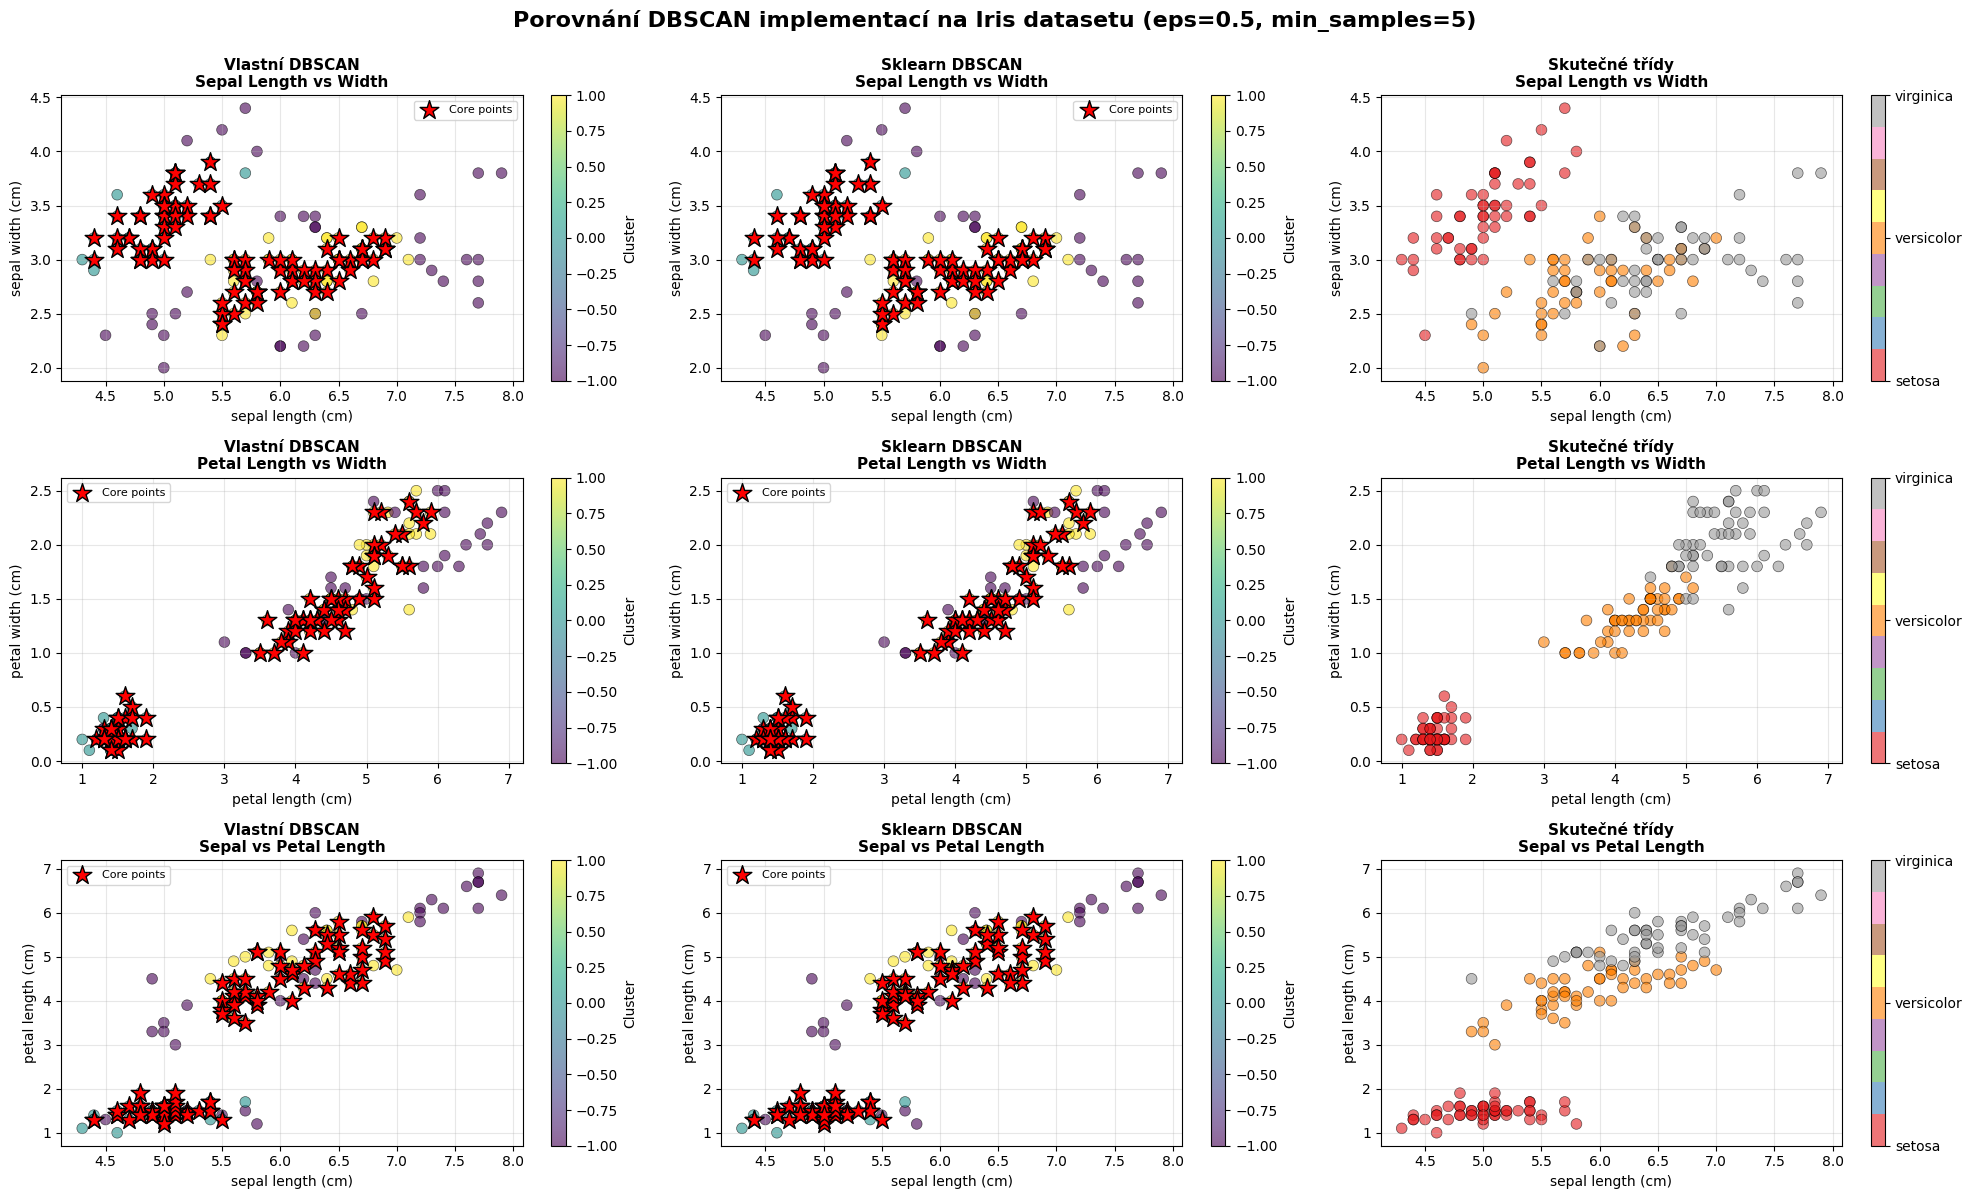

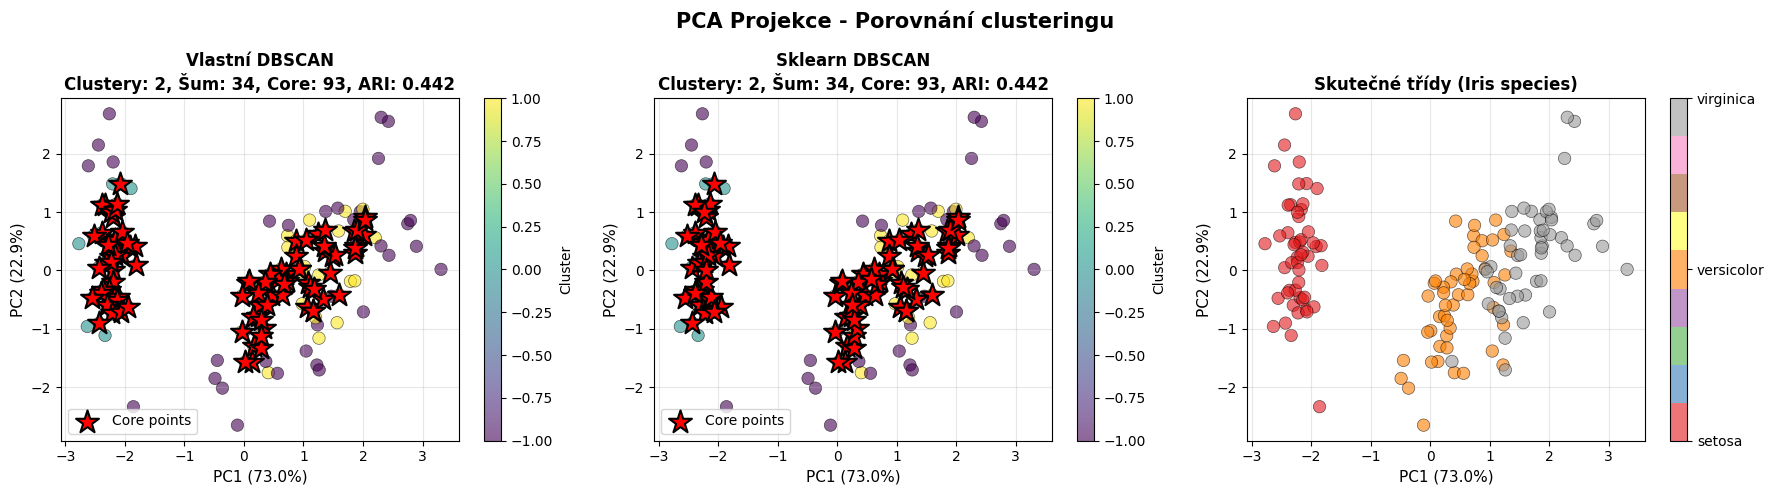

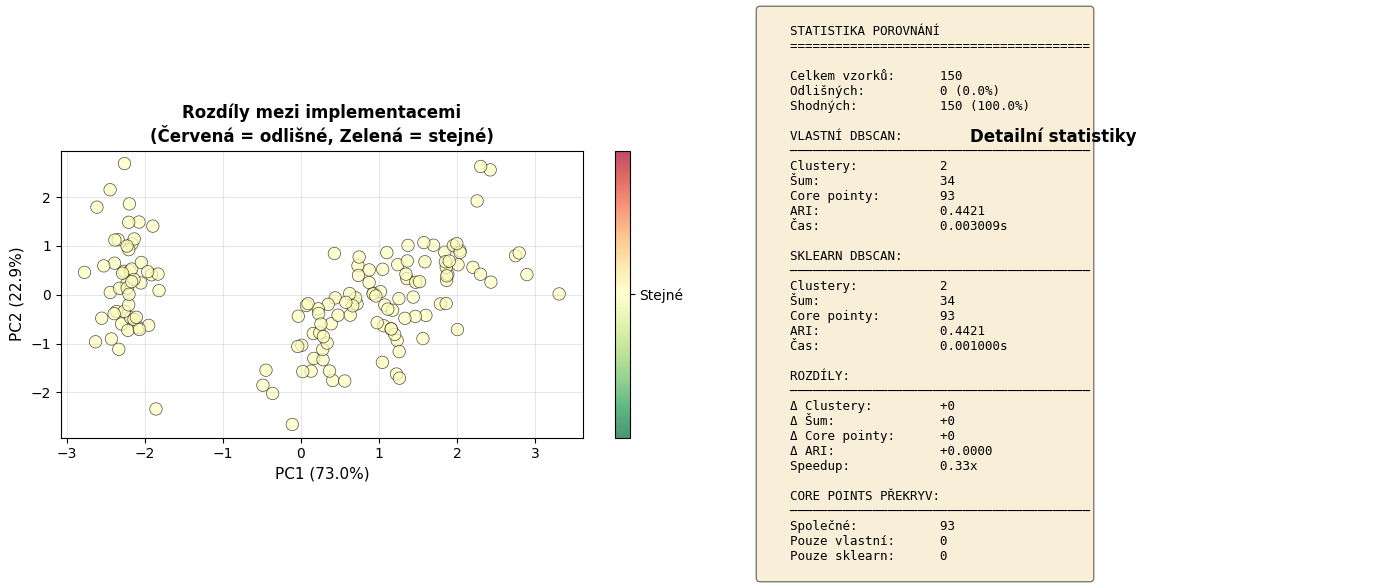

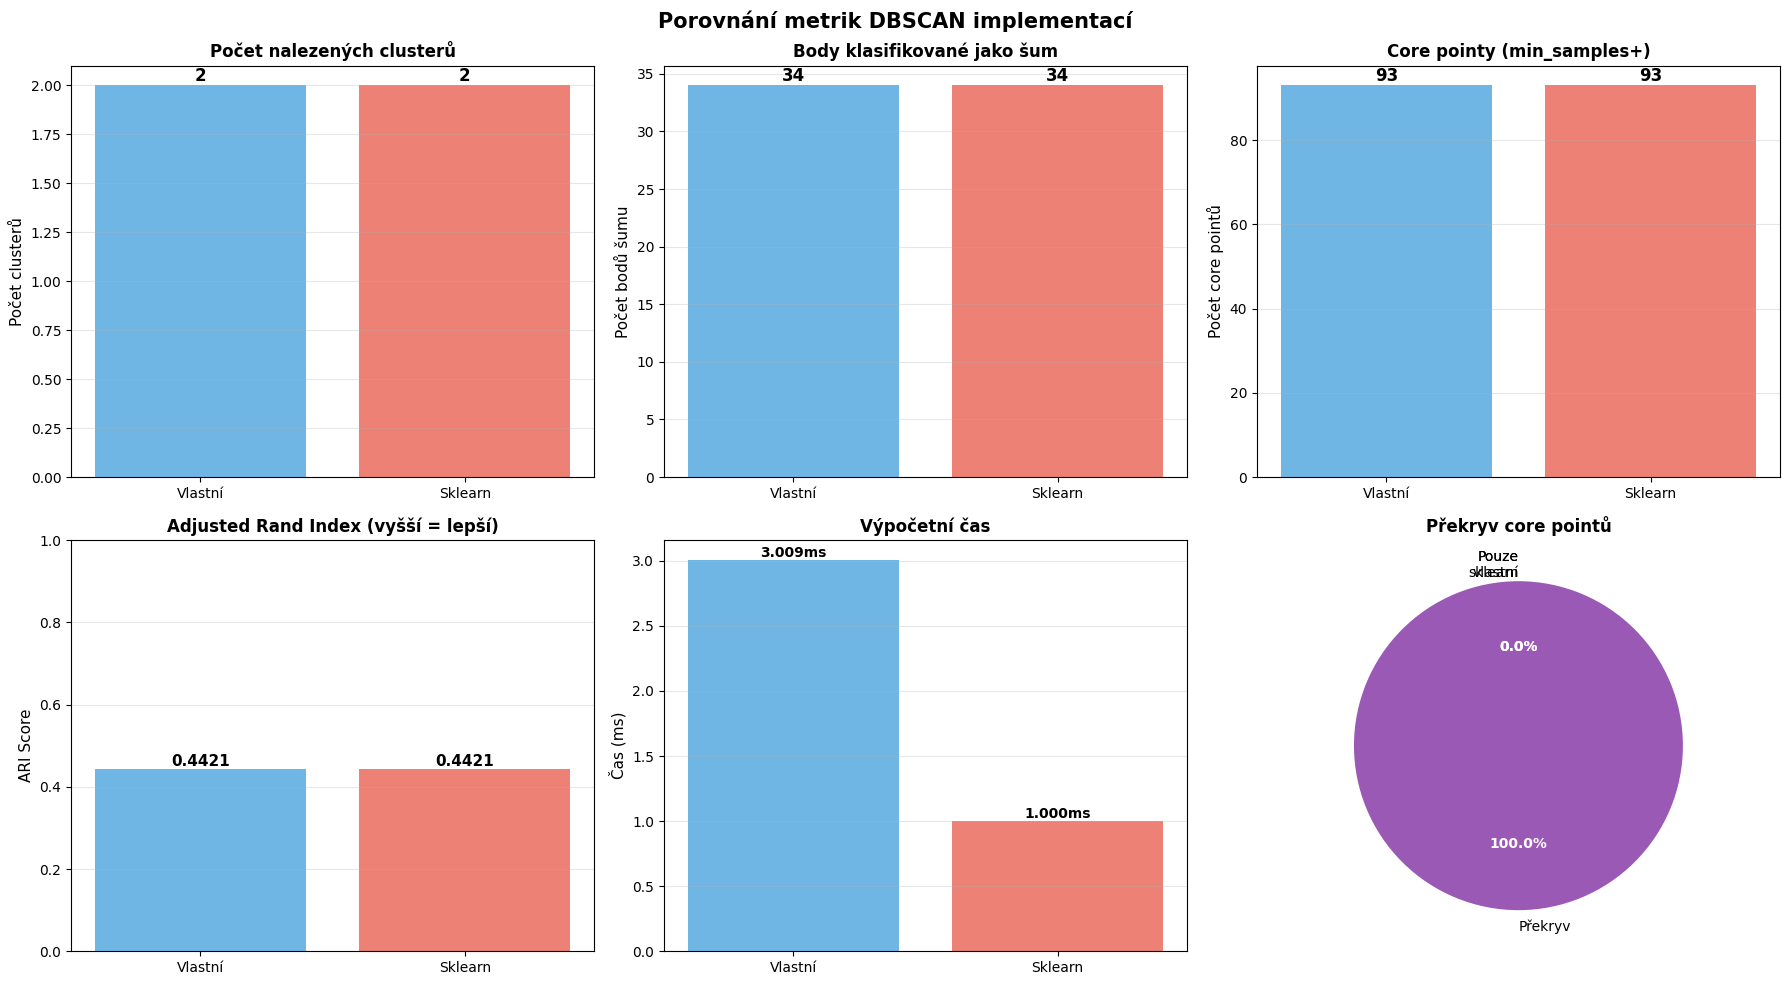

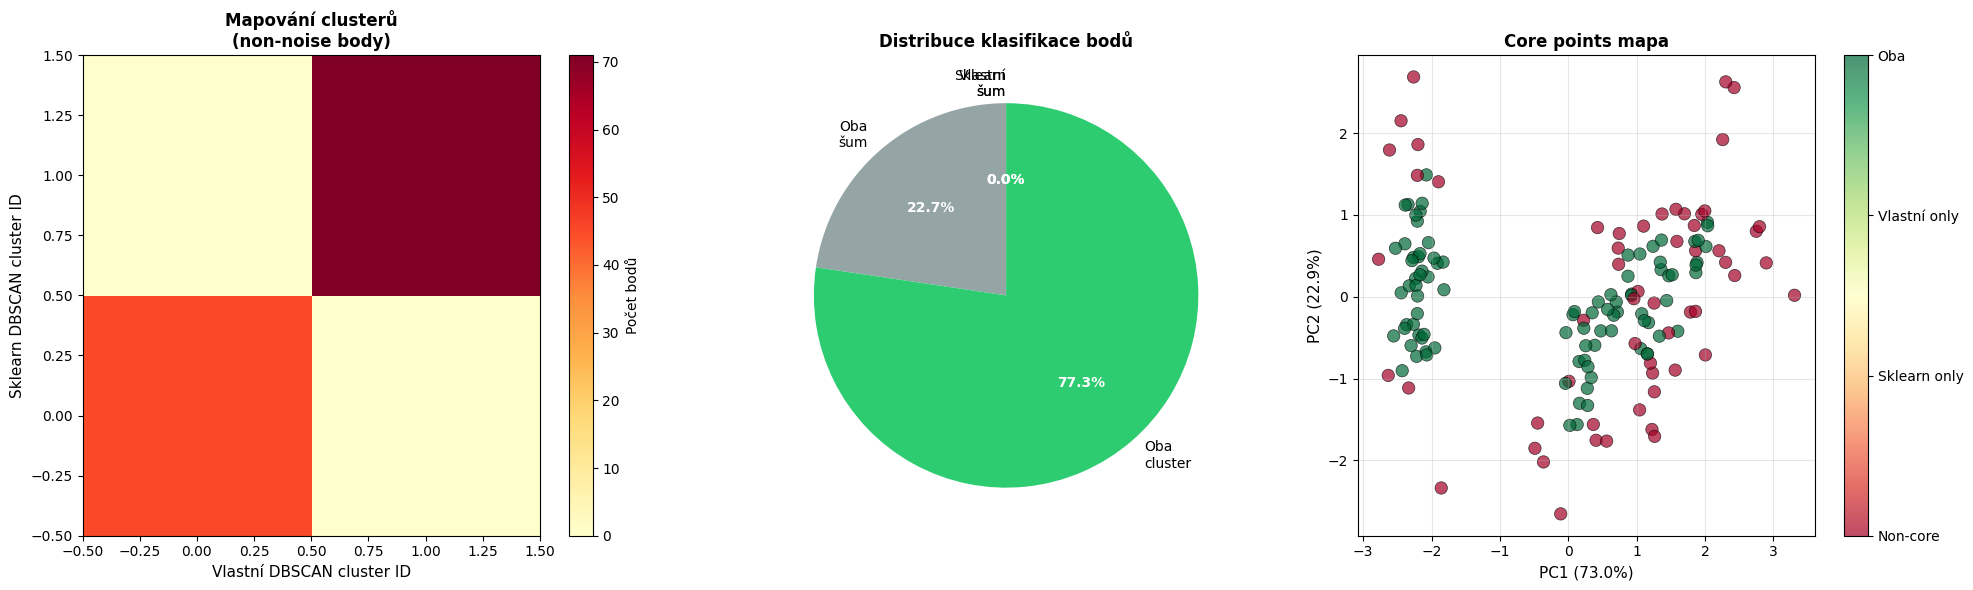

In [12]:
   
results = compare_implementations()
